## Libraries and Settings

In [1]:
library(tidyverse)
library(monocle3)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append,

In [2]:
options(repr.plot.res = 200)
options(repr.plot.width = 15)

## Import

In [3]:
cds <- new_cell_data_set(
  expression_data = t(Matrix::readMM("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/matrix.mtx")),
  cell_metadata =  read.csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/obs.csv", row.names = "X"),
  gene_metadata = read.csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/var.csv", row.names = "X")
)

cds

Warning message in new_cell_data_set(expression_data = t(Matrix::readMM("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/matrix.mtx")), :
“gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”
'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



class: cell_data_set 
dim: 32286 17029 
metadata(1): cds_version
assays(1): counts
rownames(32286): Xkr4 Gm1992 ... AC149090.1 pSL21-VEX
rowData names(14): gene_ids feature_types ... mean std
colnames(17029): AAACCAAAGACGTTAT-1 AAACCAAAGATGAAGC-1 ...
  GTTGTGCAGGGATGAT-1 GTTGTGGGTCCGTGTT-1
colData names(22): spleen.CD62Lpos spleen.CD62Lneg ...
  mixscape_class_global Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## PP + Reduction

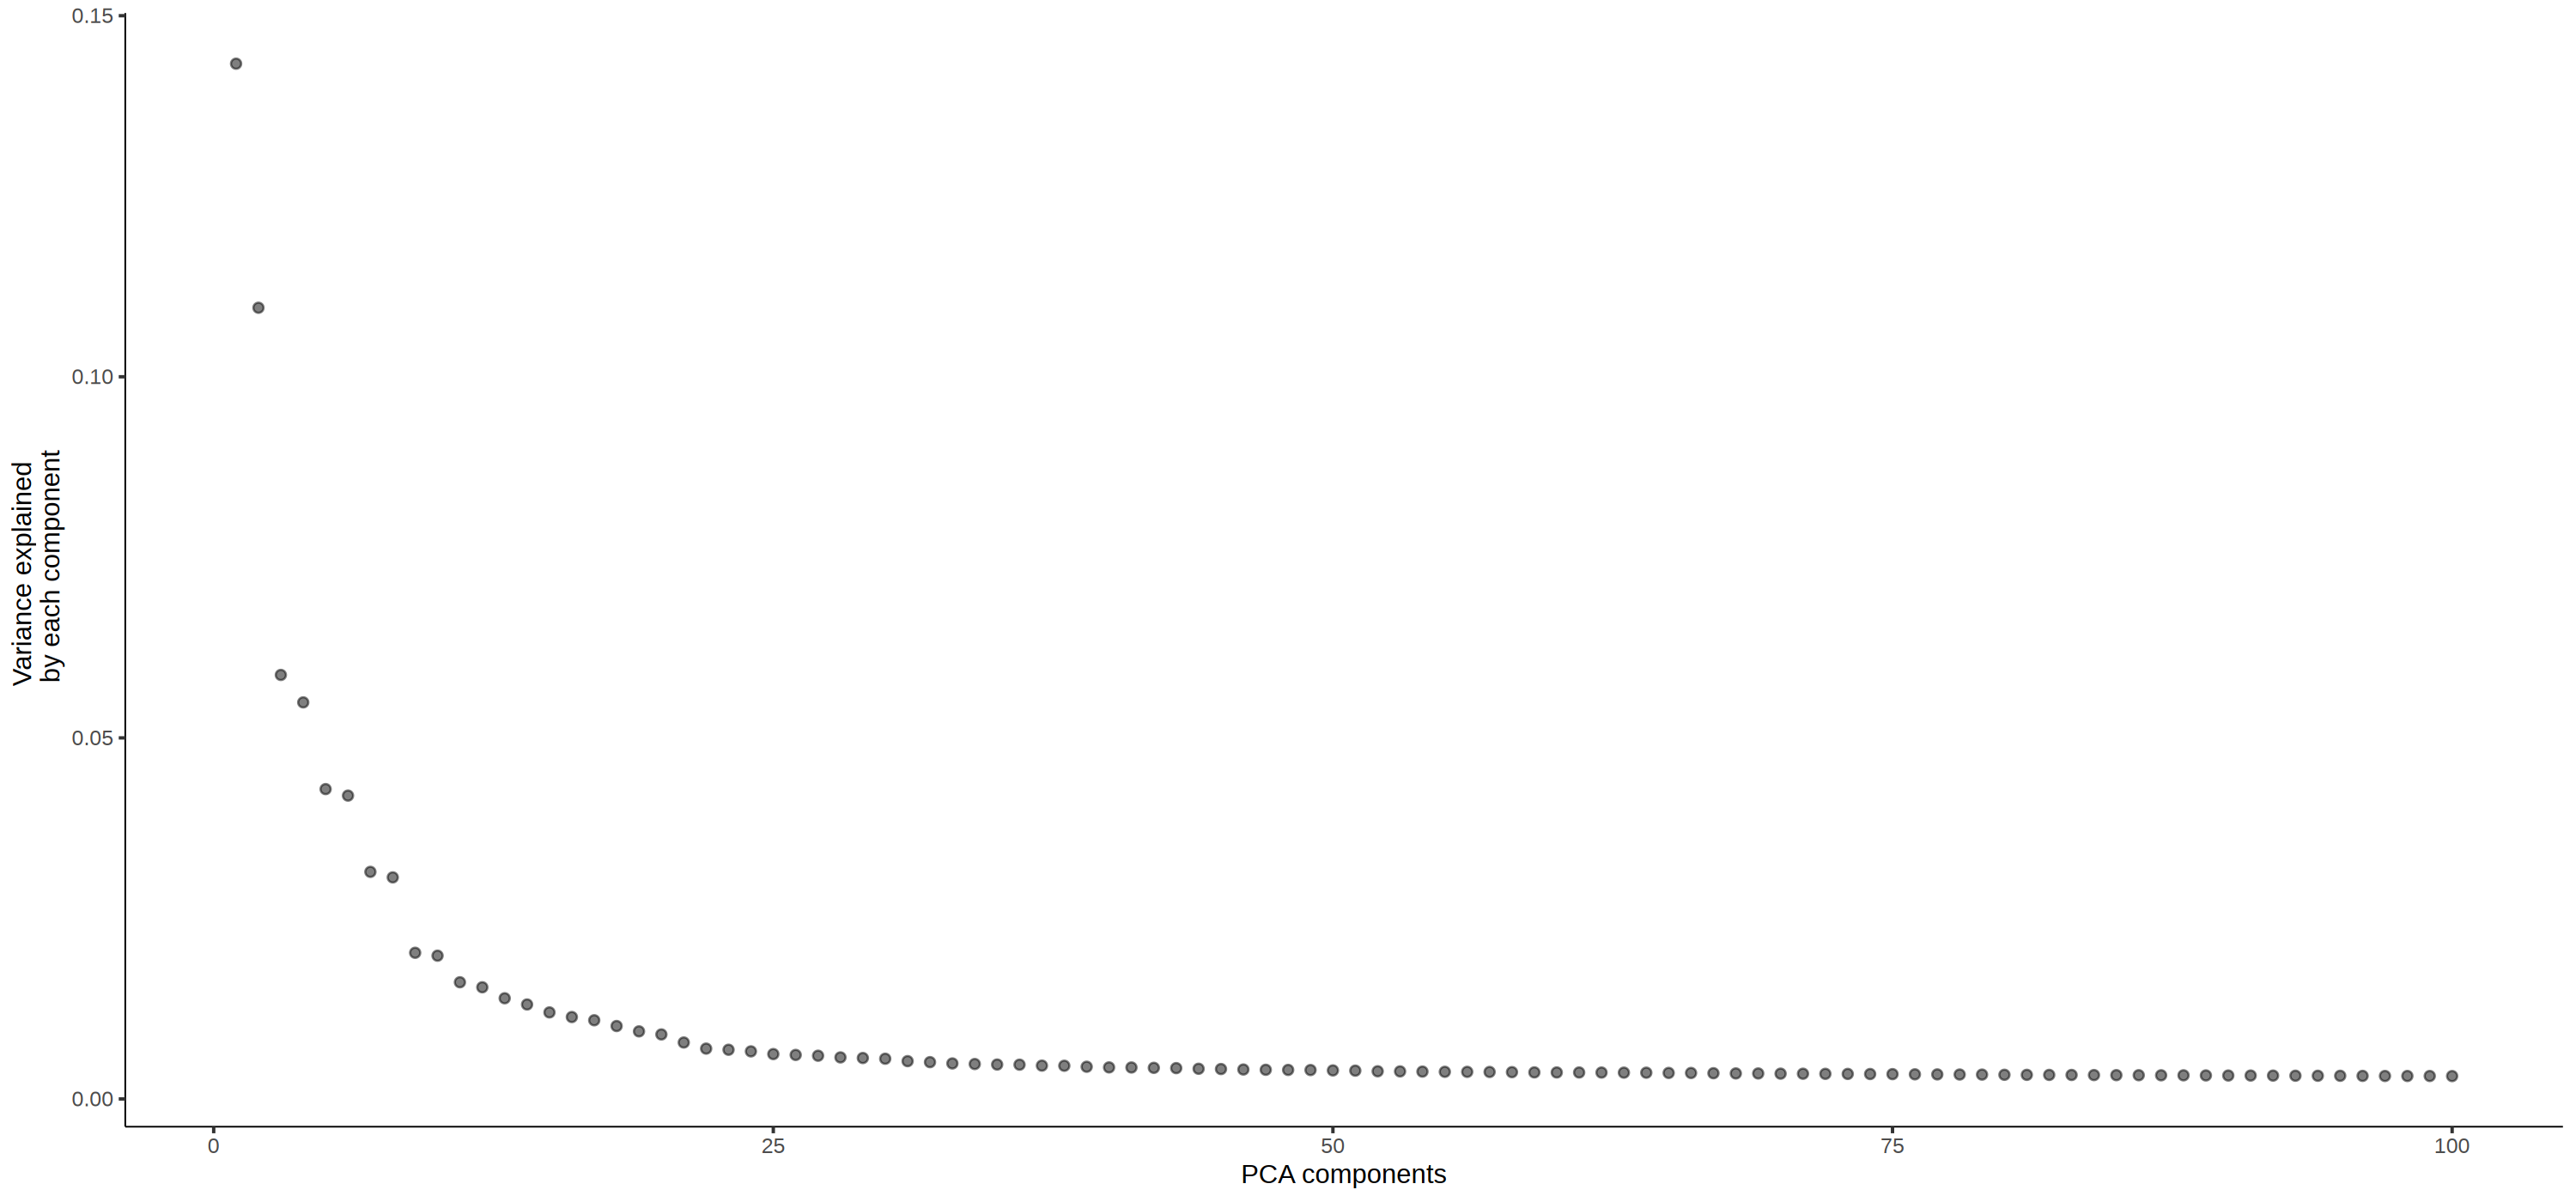

In [4]:
cds <- preprocess_cds(cds, num_dim = 100)

plot_pc_variance_explained(cds)

## Subset on KO

In [ ]:
ko_cds <-
  cds %>% 
  colData() %>% 
  as_tibble() %>% 
  pull(mixscape_class) %>% 
  str_detect("KO") %>% 
  cds[, .]

In [ ]:
ko_cds <- reduce_dimension(
  ko_cds, 
  reduction_method = "UMAP",
  preprocess_method = "PCA",
  max_components = 25, 
  cores = 60
)

In [ ]:

p <- plot_cells(ko_cds, color_cells_by = "mixscape_class")

p$layers[[3]]$aes_params$size <- 4

p

In [ ]:
rowData(ko_cds)$gene_short_name <- ko_cds |> rowData() |> rownames()

rowData(ko_cds)$is_rb <-
    ko_cds |>
    rowData() |>
    rownames() |> 
    str_detect("Rps|Rpl")

ko_cds <- ko_cds[!rowData(ko_cds)$is_rb, ]

In [ ]:
gene_fits <- fit_models(ko_cds, model_formula_str = "~mixscape_class", cores = 60)

fit_coefs <- gene_fits %>% 
  coefficient_table()

results <- 
  fit_coefs %>% 
  filter(str_detect(term, "mixscape_class")) %>% 
  filter(q_value <= 0.05) %>% 
  select(gene_short_name, term, q_value, estimate)

In [ ]:
results %>% 
    filter(-log10(q_value) > 10) |>
    ggplot(aes(x = estimate, y = -log10(q_value))) +
    geom_point() +
    facet_wrap(~term) +
    ggrepel::geom_label_repel(aes(label = gene_short_name), max.overlaps = 15) +
    theme_minimal()

## Repeat Analysis with NT base case

- I think we should repeat this analysis to find things that are differentially expressed relative to the NT rather than IGFgKO vs TGFbKO

In [5]:
colData(cds)$perturbation <-
    cds |>
    colData() |>
    as.data.frame() |>
    mutate(perturbation = fct(case_when(
        mixscape_class == "Tgfbr2 KO" ~ "Tgfbr2 KO",
        mixscape_class == "Ifngr1 KO" ~ "Ifngr1 KO",
        TRUE ~ "NP"
    ))) |>
    mutate(perturbation = fct_relevel(perturbation, "NP")) |>
    pull(perturbation)

rowData(cds)$is_rb <-
    cds |> 
    rowData() |>
    as_tibble(rownames = "gene_name") |>
    pull("gene_name") |>
    str_starts("Rpl|Rps")

cds <- cds[!rowData(cds)$is_rb, ]

In [6]:
gene_fits <- fit_models(cds, model_formula_str = "~perturbation", cores = 60)
fits_coefs <- coefficient_table(gene_fits)

In [ ]:
terms_df <- 
    fits_coefs |>
    select(gene_id, term, q_value, estimate) |> 
    as.data.frame() |>
    filter(q_value <= 0.05, term != "(Intercept)") 

Warning message:
“ggrepel: 1497 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 15214 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


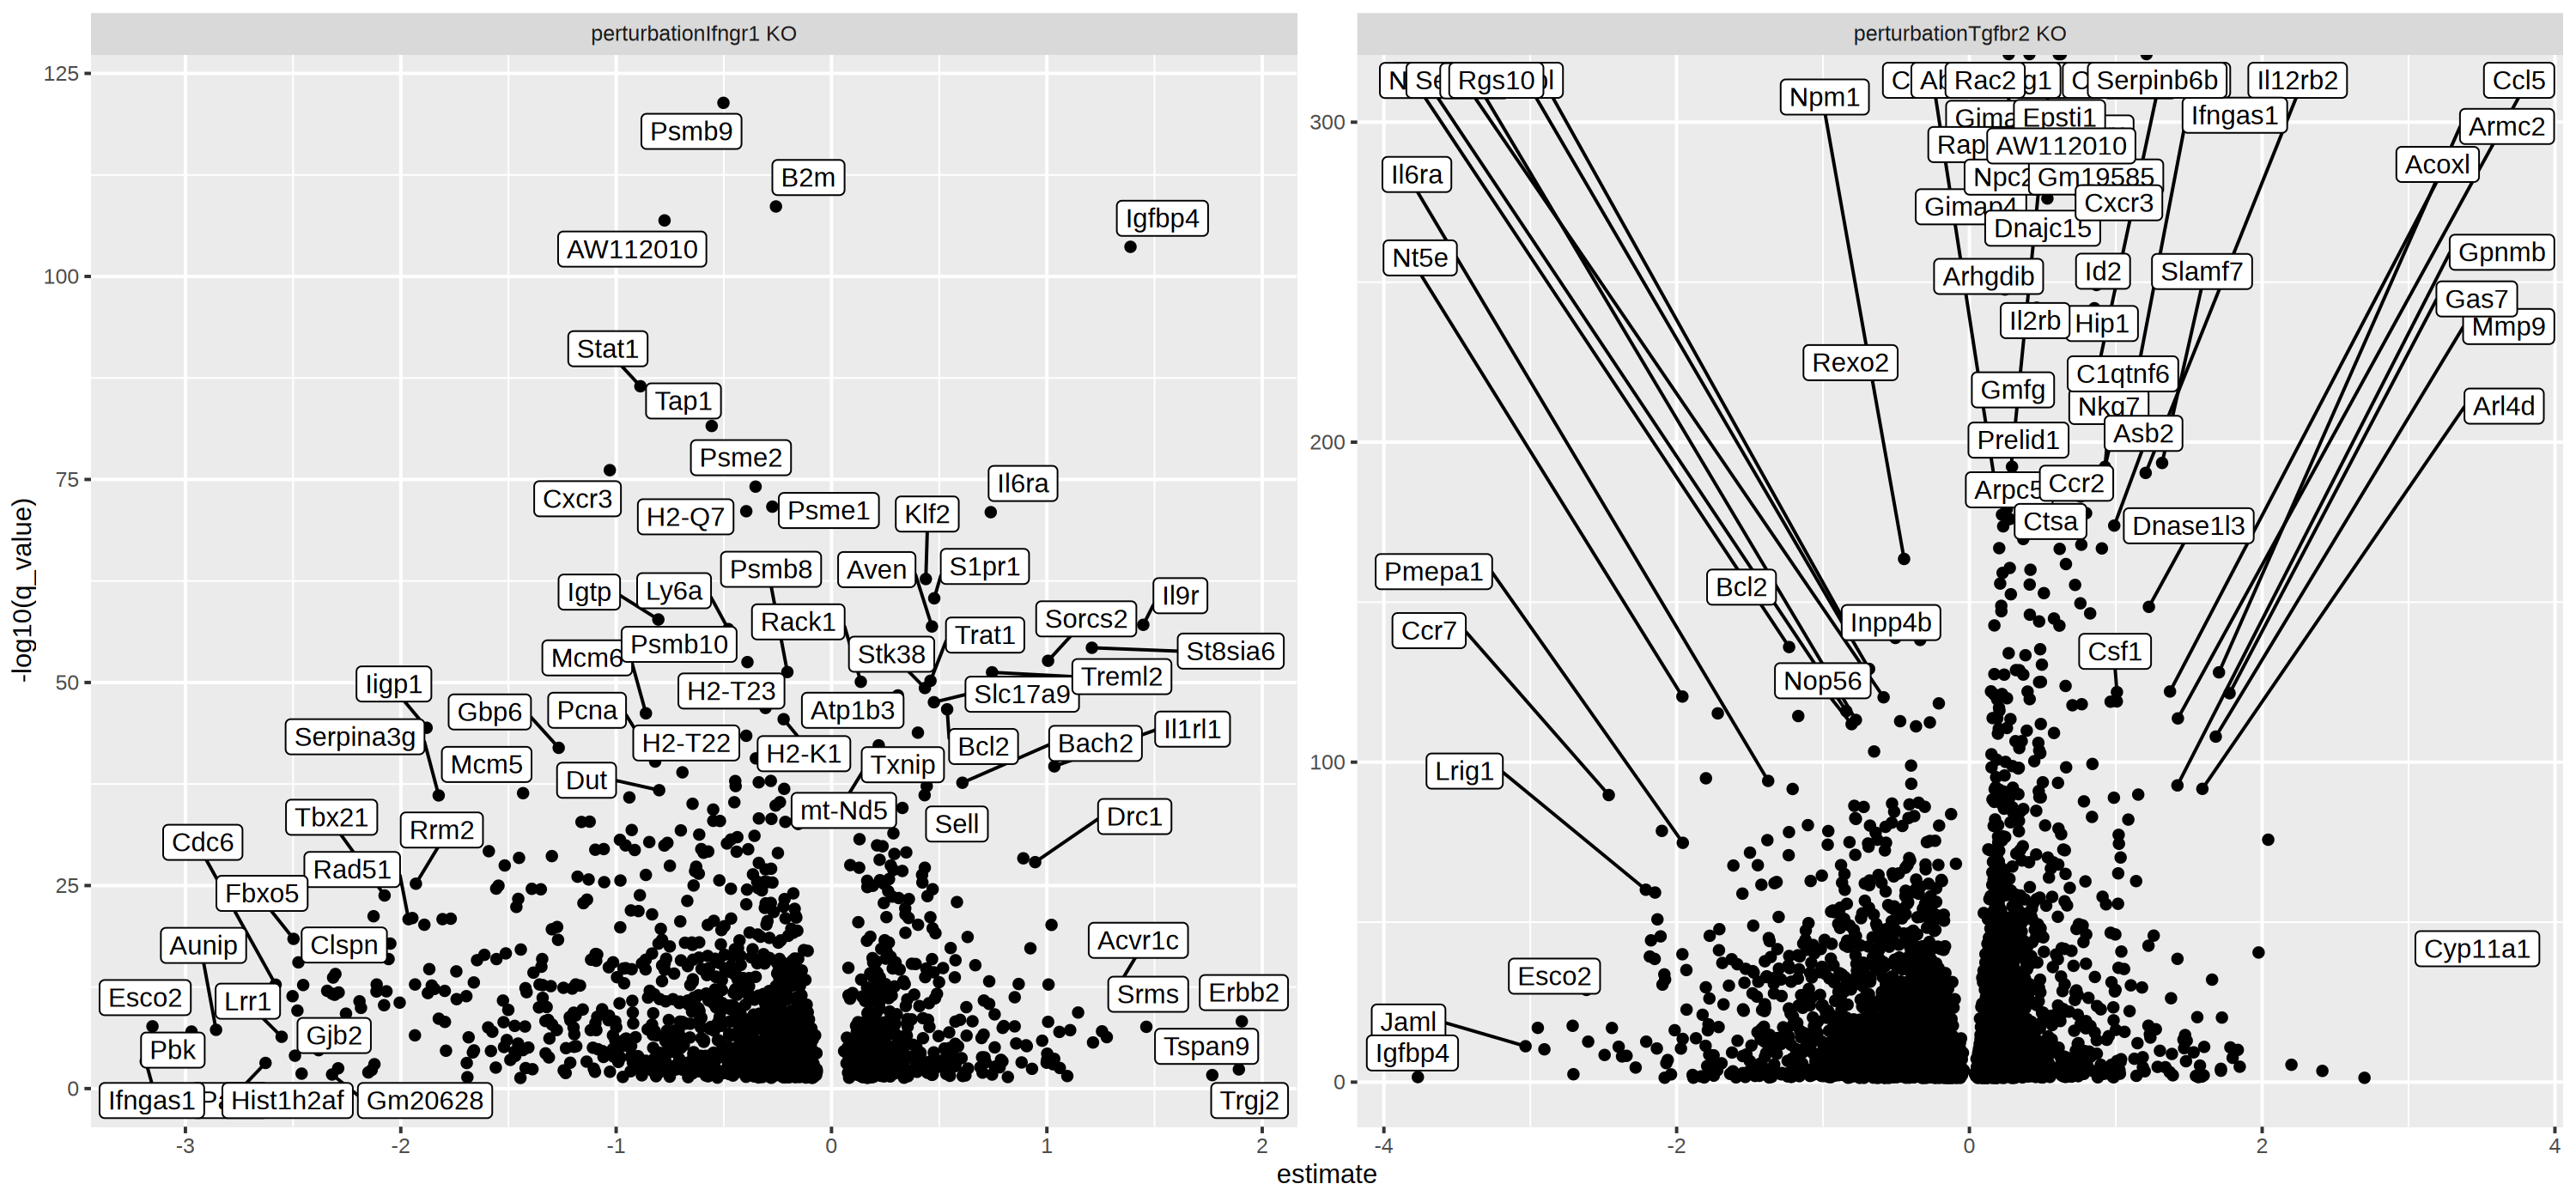

In [8]:
terms_df |>
    ggplot(aes(estimate, -log10(q_value))) +
    geom_point() +
    facet_wrap(~term,scales = "free") +
    ggrepel::geom_label_repel(aes(label = gene_id), max.overlaps = 30)

In [25]:
ifngKO_genes <-
    terms_df |>
    filter(term == "perturbationIfngr1 KO") |>
    arrange(desc(estimate)) |>
    slice_head(n = 50) |> 
    pull(gene_id)

In [28]:
rowData(cds)$gene_short_name <- row.names(rowData(cds))

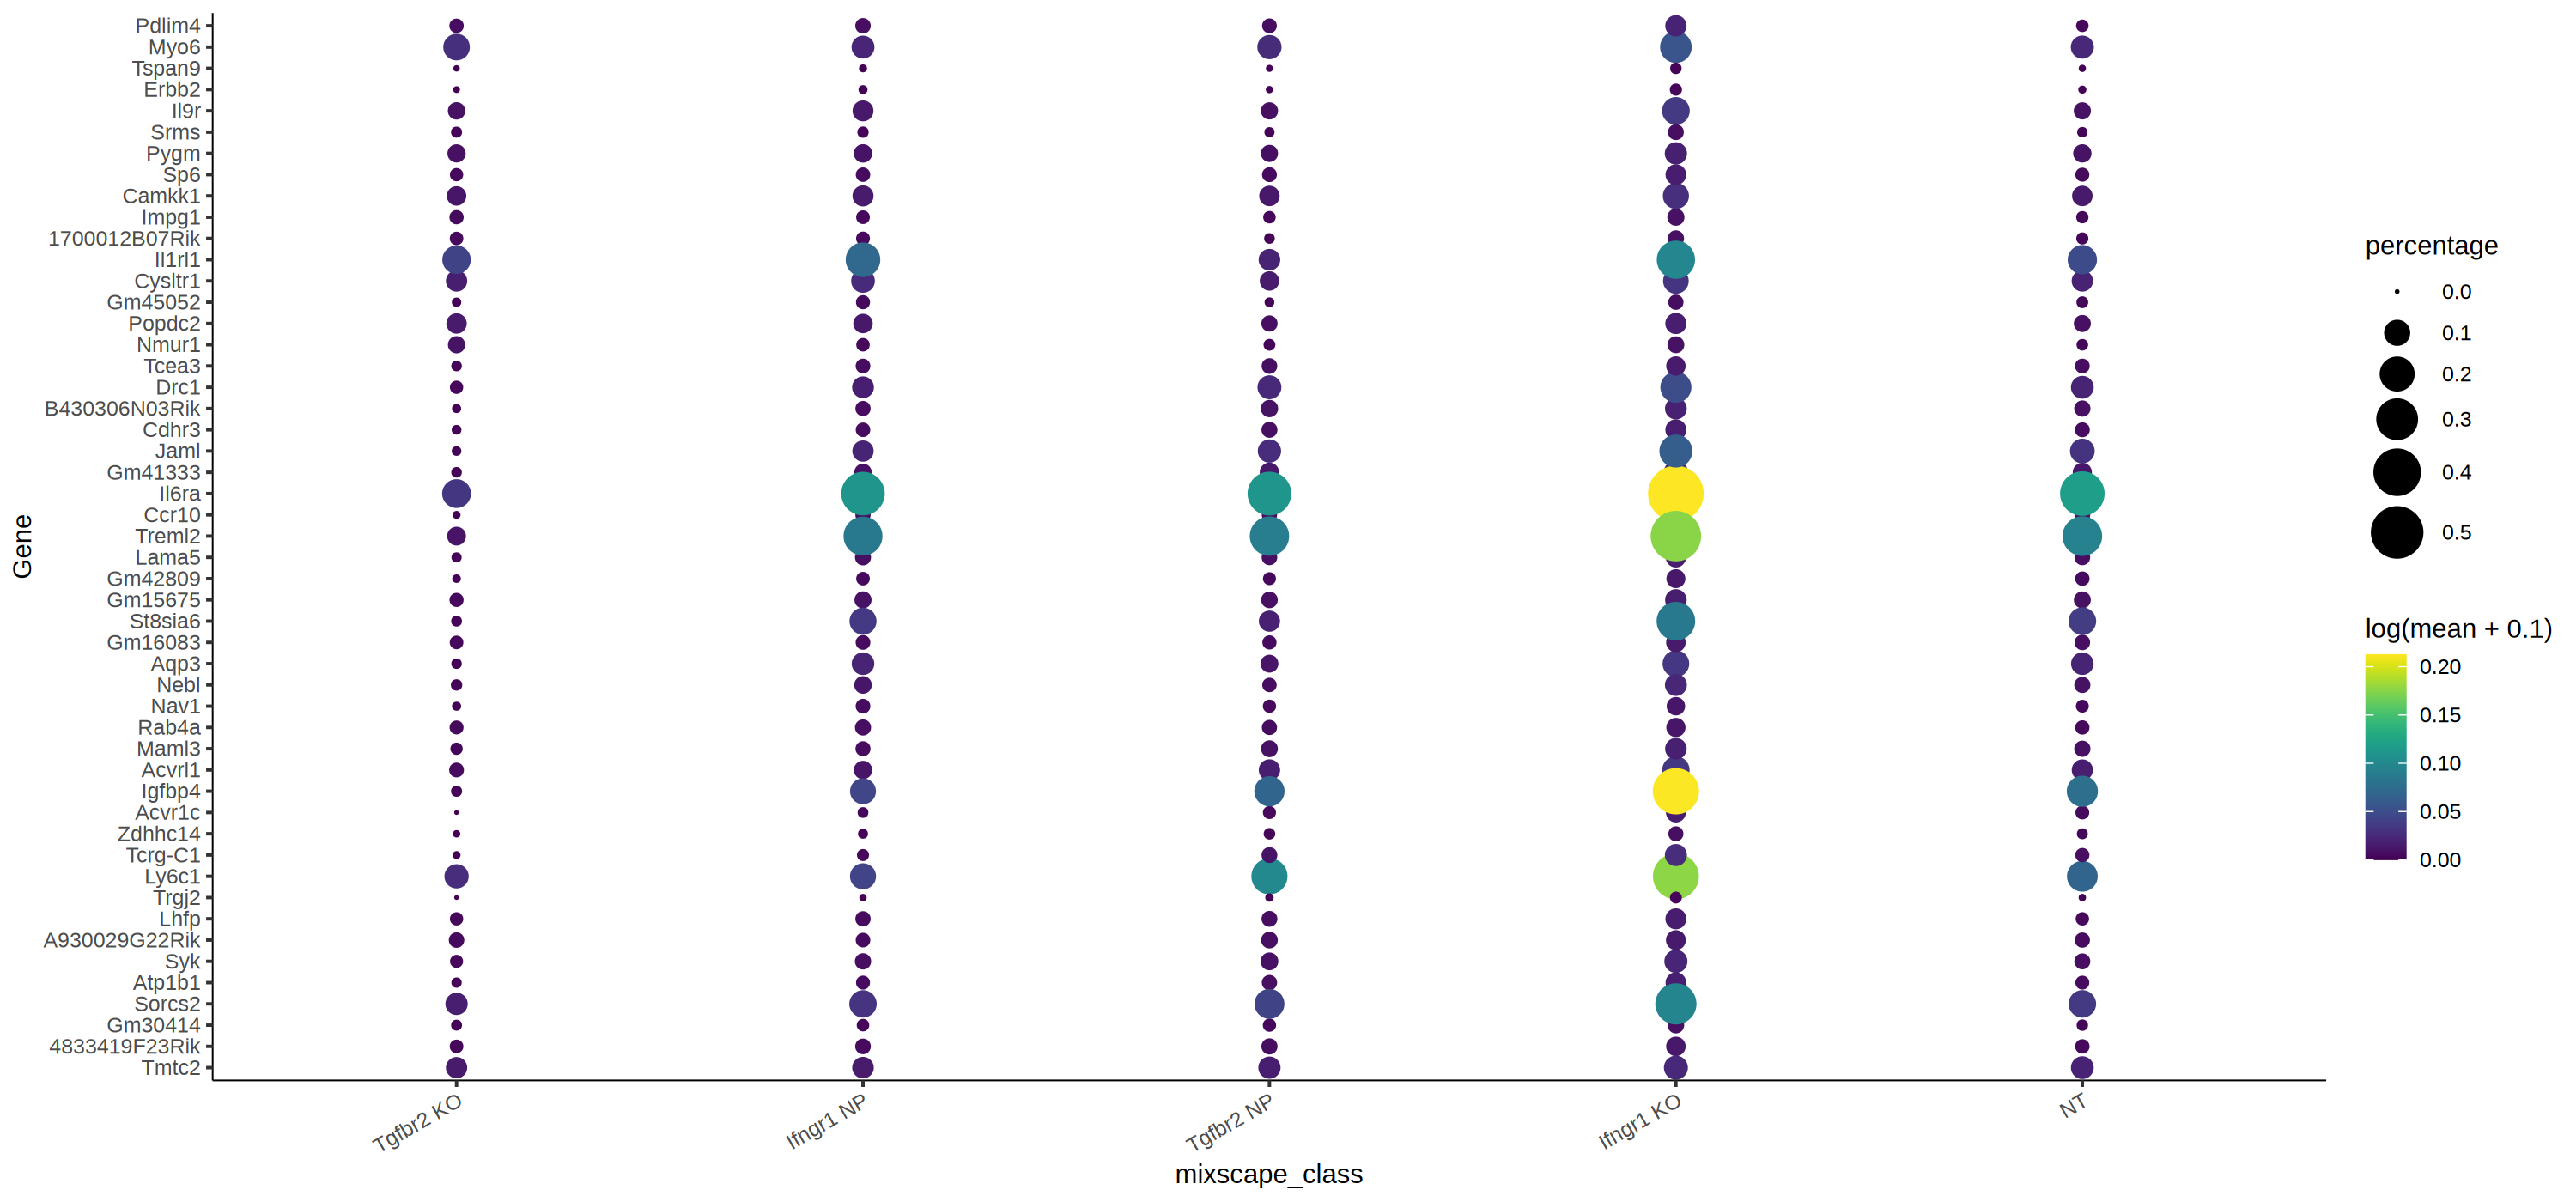

In [29]:
plot_genes_by_group(cds, ifngKO_genes, group_cells_by ="mixscape_class")

## Trajectory Analysis

In [45]:
cds <- new_cell_data_set(
  expression_data = t(Matrix::readMM("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/matrix.mtx")),
  cell_metadata =  read.csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/obs.csv", row.names = "X"),
  gene_metadata = read.csv("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/var.csv", row.names = "X")
)

colData(cds)$perturbation <-
    cds |>
    colData() |>
    as.data.frame() |>
    mutate(perturbation = fct(case_when(
        mixscape_class == "Tgfbr2 KO" ~ "Tgfbr2 KO",
        mixscape_class == "Ifngr1 KO" ~ "Ifngr1 KO",
        TRUE ~ "NP"
    ))) |>
    mutate(perturbation = fct_relevel(perturbation, "NP")) |>
    pull(perturbation)

cds <- cds[, colData(cds)$perturbation != "NP"]

Warning message in new_cell_data_set(expression_data = t(Matrix::readMM("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr_10x/matrix.mtx")), :
“gene_metadata must contain a column verbatim named 'gene_short_name' for certain functions.”


In [46]:
cds <- preprocess_cds(cds, num_dim = 50)
cds <- reduce_dimension(cds, cores = 60)

No preprocess_method specified, using preprocess_method = 'PCA'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'



In [60]:
cds <- cluster_cells(cds, reduction_method = "UMAP", k = 10)

In [62]:
cds <- learn_graph(cds)

  |======================================================================| 100%
  |======================================================================| 100%


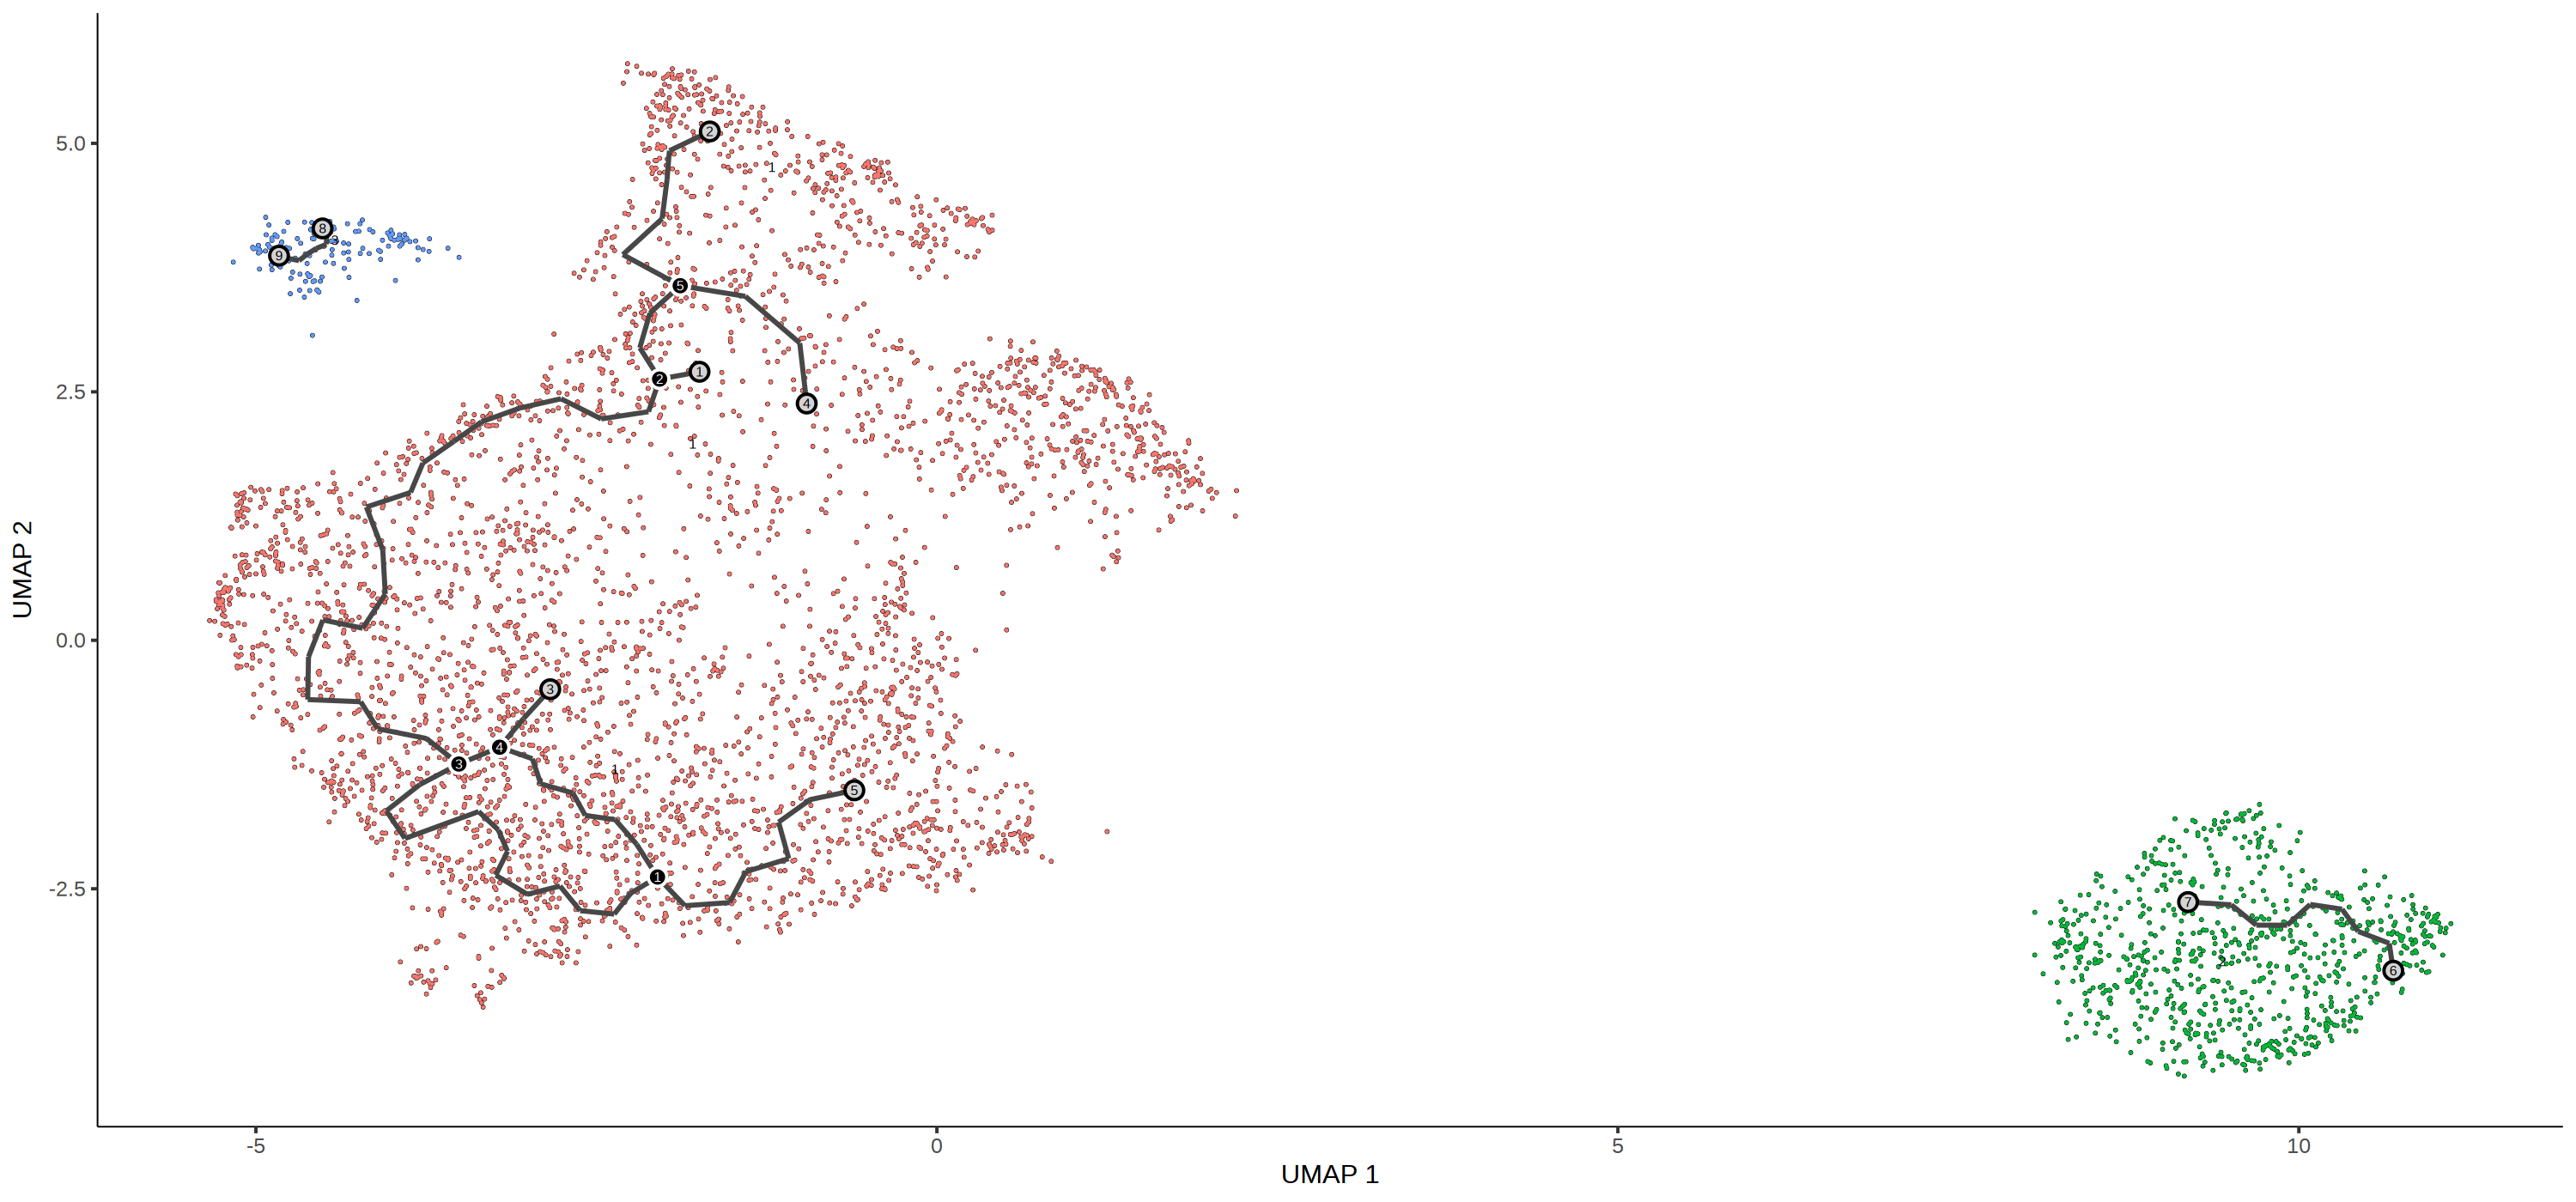

In [64]:
p <- plot_cells(cds, color_cells_by = "partition")

p